In [21]:
import numpy as np
import matplotlib.pyplot as plt
import OpenVisus as ov
import cartopy.crs as ccrs
import cartopy.feature as cfeature

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm
    print("Using regular tqdm instead of notebook version")
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# Set up environment
import os
os.environ['VISUS_CACHE'] = "./visus_can_be_deleted"

In [22]:
def load_temperature_dataset():
    """
    Load the theta (temperature) dataset and return the database object
    """
    variable = 'theta'
    field = f"https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_{variable}/llc2160_{variable}.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
    
    db = ov.LoadDataset(field)
    print(f'Dimensions: {db.getLogicBox()[1][0]}*{db.getLogicBox()[1][1]}*{db.getLogicBox()[1][2]}')
    print(f'Total Timesteps: {len(db.getTimesteps())}')
    print(f'Field: {db.getField().name}')
    print('Data Type: float32')
    
    return db

In [23]:
def read_temperature_data(db, timestep=0, resolution=-10):
    """
    Read temperature data for a specific timestep
    
    Parameters:
    db (ov.Dataset): OpenVisus dataset object
    timestep (int): Timestep to read
    resolution (int): Resolution level (-15 to 0)
    
    Returns:
    np.ndarray: Temperature data
    """
    data = db.read(time=timestep, quality=resolution)
    print(f"Data shape: {data.shape}")
    print(f"Data min: {np.nanmin(data)}, max: {np.nanmax(data)}")
    
    # If data is 3D (has depth dimension), return the surface layer
    if len(data.shape) == 3:
        return data[0]  # First depth level (surface)
    else:
        return data

In [47]:
def visualize_temperature(data, vmin=0, vmax=33, cmap='turbo', title='Sea Surface Temperature (Theta)', 
                          save_path='temperature_visualization.png'):
    """
    Create and save a visualization of temperature data
    
    Parameters:
    data (np.ndarray): Temperature data array
    vmin (float): Minimum value for colormap
    vmax (float): Maximum value for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    plt.figure(figsize=(12, 8))
    
    # Create the plot with temperature colormap
    im = plt.imshow(data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    plt.title(title)
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Visualization saved as '{save_path}'")

new2

In [25]:
def visualize_indian_ocean_region(data, y_slice=(0.45, 0.71), x_slice=(0.2, 0.6), 
                                 western_region=(0.24, 0.31, 0.57, 0.66),
                                 eastern_region=(0.35, 0.41, 0.57, 0.61),
                                 vmin=0, vmax=33, cmap='turbo', 
                                 title='Indian Ocean Region Sea Surface Temperature',
                                 save_path='indian_ocean_temperature.png'):
    """
    Create and save a visualization focused on the Indian Ocean region with IOD region boxes
    
    Parameters:
    data (np.ndarray): Full temperature data array
    y_slice (tuple): Relative start and end points for y-axis (0-1)
    x_slice (tuple): Relative start and end points for x-axis (0-1)
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) for Western IOD region
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) for Eastern IOD region
    vmin (float): Minimum value for colormap
    vmax (float): Maximum value for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate region boundaries
    y_start = int(data.shape[0] * y_slice[0])
    y_end = int(data.shape[0] * y_slice[1])
    x_start = int(data.shape[1] * x_slice[0])
    x_end = int(data.shape[1] * x_slice[1])
    
    # Extract the region of interest
    region_data = data[y_start:y_end, x_start:x_end]
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Define coordinate ranges
    lon_range = (37, 175)  # 37°E to 175°E
    lat_range = (-37, 37)  # 37°S to 37°N
    
    # Create the plot with temperature colormap
    im = ax.imshow(region_data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, 
                   extent=[lon_range[0], lon_range[1], lat_range[0], lat_range[1]])
    
    # Function to convert relative coordinates to lon/lat values
    def rel_to_lon(x_rel):
        # Map from relative position to longitude
        # Account for the fact that we're looking at a slice of the full data
        rel_within_slice = (x_rel - x_slice[0]) / (x_slice[1] - x_slice[0])
        # Map to the longitude range
        lon = lon_range[0] + rel_within_slice * (lon_range[1] - lon_range[0])
        return lon
    
    def rel_to_lat(y_rel):
        # Map from relative position to latitude
        # Account for the fact that we're looking at a slice of the full data
        rel_within_slice = (y_rel - y_slice[0]) / (y_slice[1] - y_slice[0])
        # Map to the latitude range
        lat = lat_range[0] + rel_within_slice * (lat_range[1] - lat_range[0])
        return lat
    
    # Calculate IOD region coordinates in longitude/latitude
    west_lon_start = rel_to_lon(western_region[0])
    west_lon_end = rel_to_lon(western_region[1])
    west_lat_start = rel_to_lat(western_region[2])
    west_lat_end = rel_to_lat(western_region[3])
    
    east_lon_start = rel_to_lon(eastern_region[0])
    east_lon_end = rel_to_lon(eastern_region[1])
    east_lat_start = rel_to_lat(eastern_region[2])
    east_lat_end = rel_to_lat(eastern_region[3])
    
    # Create rectangles for the IOD regions
    west_rect = plt.Rectangle((west_lon_start, west_lat_start), 
                            west_lon_end - west_lon_start, 
                            west_lat_end - west_lat_start,
                            linewidth=2, edgecolor='white', facecolor='none')
    ax.add_patch(west_rect)
    
    east_rect = plt.Rectangle((east_lon_start, east_lat_start), 
                            east_lon_end - east_lon_start, 
                            east_lat_end - east_lat_start,
                            linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(east_rect)
    
    # Add labels for the regions (positioned below/above the rectangles)
    ax.text(west_lon_start, west_lat_start - 5, 
           f'Western IOD: 50°E-70°E', 
           color='white', fontsize=9, weight='bold',
           bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3'))
    
    ax.text(east_lon_start, east_lat_end + 5, 
           f'Eastern IOD: 90°E-110°E', 
           color='black', fontsize=9, weight='bold',
           bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.3'))
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set x ticks (longitude) - create evenly spaced ticks
    lon_ticks = np.linspace(lon_range[0], lon_range[1], 10)
    ax.set_xticks(lon_ticks)
    ax.set_xticklabels([f'{int(lon)}°E' for lon in lon_ticks])
    
    # Set y ticks (latitude) - create evenly spaced ticks
    lat_ticks = np.linspace(lat_range[0], lat_range[1], 10)
    ax.set_yticks(lat_ticks)
    ax.set_yticklabels([f'{int(lat)}°N' if lat >= 0 else f'{abs(int(lat))}°S' for lat in lat_ticks])
    
    # Set axis labels
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)')
    
    # Add title
    ax.set_title(title, fontsize=14, pad=10)
    
    # Print the actual coordinates
    print(f"Western IOD region: {west_lon_start:.1f}°E to {west_lon_end:.1f}°E, {west_lat_start:.1f}°S to {west_lat_end:.1f}°N")
    print(f"Eastern IOD region: {east_lon_start:.1f}°E to {east_lon_end:.1f}°E, {east_lat_start:.1f}°S to {east_lat_end:.1f}°N")
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.show()  # Show in notebook
    print(f"Visualization saved as '{save_path}'")
    print(f"Coordinate ranges: longitude {lon_range[0]}°E to {lon_range[1]}°E, latitude {abs(lat_range[0])}°S to {lat_range[1]}°N")

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: theta
Data Type: float32
Data shape: (6, 810, 1080)
Data min: -2.16780161857605, max: 32.9277229309082
Western IOD region: 50.8°E to 74.9°E, -2.8°S to 22.8°N
Eastern IOD region: 88.8°E to 109.4°E, -2.8°S to 8.5°N


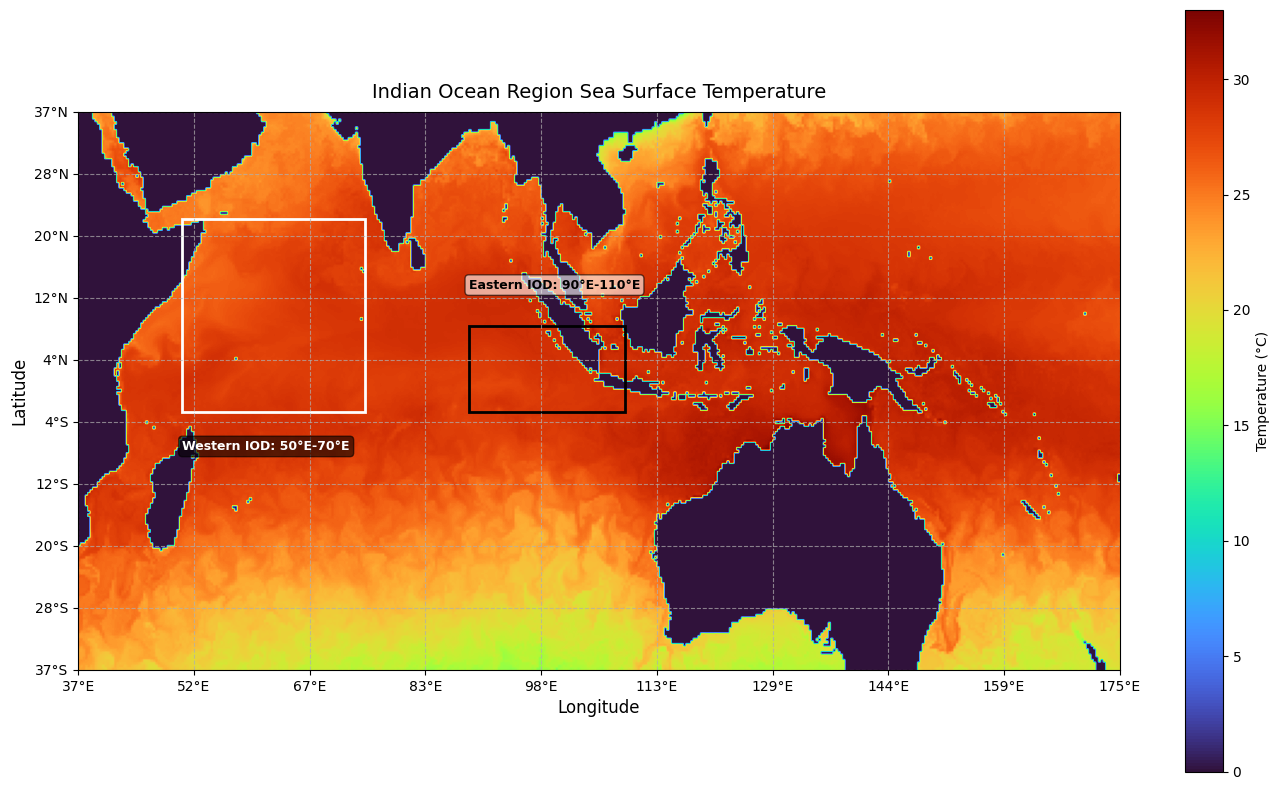

Visualization saved as 'indian_ocean_temperature.png'
Coordinate ranges: longitude 37°E to 175°E, latitude 37°S to 37°N


Exception: query error cannot allocate buffer

In [26]:
# Load the dataset
db = load_temperature_dataset()

# Read temperature data for timestep 0
temp_data = read_temperature_data(db, timestep=0, resolution=-10)

# Create a visualization of the full dataset
# visualize_temperature(temp_data)

# Create a visualization focused on the Indian Ocean region
visualize_indian_ocean_region(temp_data)

# To create visualizations for multiple timesteps:
# for ts in range(0, 10, 2):  # Every 2nd timestep from 0 to 8
#     temp_data = read_temperature_data(db, timestep=ts, resolution=-15)
#     visualize_temperature(temp_data, save_path=f'temperature_ts_{ts}.png', 
#                          title=f'Sea Surface Temperature - Timestep {ts}')

for ts in range(0, 10296, 24):  # Every 2nd timestep from 0 to 8
    temp_data = read_temperature_data(db, timestep=ts, resolution=0)
    visualize_indian_ocean_region(temp_data, save_path=f'iod_temperature_ts_{ts}.png', 
                         title=f'Sea Surface Temperature - Timestep {ts}')

In [27]:
def extract_iod_regions(data, western_region=(0.24, 0.31, 0.57, 0.66), eastern_region=(0.35, 0.41, 0.57, 0.61)):
    """
    Extract the Western and Eastern IOD regions from temperature data
    
    Parameters:
    data (np.ndarray): Temperature data array
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    
    Returns:
    tuple: (western_data, eastern_data)
    """
    # Extract Western IOD region (50°E to 70°E and 10°S to 10°N)
    west_x_start = int(data.shape[1] * western_region[0])
    west_x_end = int(data.shape[1] * western_region[1])
    west_y_start = int(data.shape[0] * western_region[2])
    west_y_end = int(data.shape[0] * western_region[3])
    
    western_data = data[west_y_start:west_y_end, west_x_start:west_x_end]
    
    # Extract Eastern IOD region (90°E to 110°E and 10°S to 0°S)
    east_x_start = int(data.shape[1] * eastern_region[0])
    east_x_end = int(data.shape[1] * eastern_region[1])
    east_y_start = int(data.shape[0] * eastern_region[2])
    east_y_end = int(data.shape[0] * eastern_region[3])
    
    eastern_data = data[east_y_start:east_y_end, east_x_start:east_x_end]
    
    return western_data, eastern_data


In [28]:
def calculate_dmi(western_data, eastern_data):
    """
    Calculate the Dipole Mode Index (DMI)
    
    Parameters:
    western_data (np.ndarray): Temperature data for Western IOD region
    eastern_data (np.ndarray): Temperature data for Eastern IOD region
    
    Returns:
    tuple: (western_mean, eastern_mean, dmi)
    """
    # Calculate mean temperatures for each region
    western_mean = np.nanmean(western_data)
    eastern_mean = np.nanmean(eastern_data)
    
    # Calculate DMI (Western mean - Eastern mean)
    dmi = western_mean - eastern_mean
    
    return western_mean, eastern_mean, dmi

new2

In [29]:
def visualize_iod_regions_exact(data, western_region=(0.24, 0.31, 0.57, 0.66), eastern_region=(0.35, 0.41, 0.57, 0.61),
                          vmin=0, vmax=33, cmap='turbo', 
                          title='Indian Ocean Dipole Regions',
                          save_path='iod_regions_exact.png'):
    """
    Visualize the IOD regions with properly aligned longitude labels:
    - Western IOD region: 50°E to 70°E
    - Eastern IOD region: 90°E to 110°E
    - Maintains latitude range of 88°S to 67°N
    
    Parameters:
    data (np.ndarray): Temperature data array
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    vmin, vmax (float): Min and max values for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    save_path (str): Path to save the visualization
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter, FixedLocator
    
    # Define the extraction function
    def extract_iod_regions(data, western_region, eastern_region):
        # Extract Western IOD region
        west_x_start = int(data.shape[1] * western_region[0])
        west_x_end = int(data.shape[1] * western_region[1])
        west_y_start = int(data.shape[0] * western_region[2])
        west_y_end = int(data.shape[0] * western_region[3])
        
        western_data = data[west_y_start:west_y_end, west_x_start:west_x_end]
        
        # Extract Eastern IOD region
        east_x_start = int(data.shape[1] * eastern_region[0])
        east_x_end = int(data.shape[1] * eastern_region[1])
        east_y_start = int(data.shape[0] * eastern_region[2])
        east_y_end = int(data.shape[0] * eastern_region[3])
        
        eastern_data = data[east_y_start:east_y_end, east_x_start:east_x_end]
        
        return western_data, eastern_data
    
    # Calculate DMI
    def calculate_dmi(western_data, eastern_data):
        western_mean = np.nanmean(western_data)
        eastern_mean = np.nanmean(eastern_data)
        dmi = western_mean - eastern_mean
        return western_mean, eastern_mean, dmi
    
    # Extract regions and calculate DMI
    western_data, eastern_data = extract_iod_regions(data, western_region, eastern_region)
    western_mean, eastern_mean, dmi = calculate_dmi(western_data, eastern_data)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Display the image without specifying extent
    im = ax.imshow(data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Define correct latitude range
    lat_min, lat_max = -88, 67  # 88°S to 67°N
    
    # Map relative coordinates to the actual longitude/latitude
    def rel_to_lat(y_rel):
        return lat_min + y_rel * (lat_max - lat_min)
    
    # Define pixel coordinates of the regions
    west_x_start = int(data.shape[1] * western_region[0])
    west_x_end = int(data.shape[1] * western_region[1])
    west_y_start = int(data.shape[0] * western_region[2])
    west_y_end = int(data.shape[0] * western_region[3])
    
    east_x_start = int(data.shape[1] * eastern_region[0])
    east_x_end = int(data.shape[1] * eastern_region[1])
    east_y_start = int(data.shape[0] * eastern_region[2])
    east_y_end = int(data.shape[0] * eastern_region[3])
    
    # Calculate position of known geographic points in the image
    width = data.shape[1]
    height = data.shape[0]
    
    # Define key longitude positions
    # Prime Meridian (0°) should be at approximately 1/8 of width
    prime_meridian_pos = width * 0.125  
    
    # Position where 50°E should be (start of Western IOD region)
    west_iod_start_pos = west_x_start
    
    # Position where 70°E should be (end of Western IOD region)
    west_iod_end_pos = west_x_end
    
    # Position where 90°E should be (start of Eastern IOD region)
    east_iod_start_pos = east_x_start
    
    # Position where 110°E should be (end of Eastern IOD region)
    east_iod_end_pos = east_x_end
    
    # Create fixed longitude positions for important points
    x_fixed_positions = [0, prime_meridian_pos, west_iod_start_pos, west_iod_end_pos, 
                         east_iod_start_pos, east_iod_end_pos, width * 0.625, width * 0.75, 
                         width * 0.875, width-1]
    
    # Assign specific longitude values to these positions
    lon_fixed_values = [-38, 0, 50, 70, 90, 110, 160, -160, -100, -38]
    
    # Create longitude labels
    lon_fixed_labels = []
    for lon in lon_fixed_values:
        if abs(lon) < 0.5:  # Close to zero
            lon_fixed_labels.append("0°")
        elif lon > 0:
            lon_fixed_labels.append(f"{int(lon)}°E")
        else:
            lon_fixed_labels.append(f"{int(abs(lon))}°W")
    
    # Set the fixed longitude ticks and labels
    ax.set_xticks(x_fixed_positions)
    ax.set_xticklabels(lon_fixed_labels)
    
    # Create evenly spaced latitude ticks
    y_positions = np.linspace(0, height-1, 10)
    lat_degrees = np.linspace(lat_min, lat_max, 10)
    lat_labels = []
    for lat in lat_degrees:
        if abs(lat) < 0.5:  # Close to equator
            lat_labels.append("0°")
        elif lat >= 0:
            lat_labels.append(f"{int(lat)}°N")
        else:
            lat_labels.append(f"{int(abs(lat))}°S")
    
    # Set the latitude ticks and labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels(lat_labels)
    
    # Create rectangles for the IOD regions
    west_rect = plt.Rectangle((west_x_start, west_y_start), 
                             west_x_end - west_x_start, 
                             west_y_end - west_y_start,
                             linewidth=2, edgecolor='white', facecolor='none')
    ax.add_patch(west_rect)
    
    east_rect = plt.Rectangle((east_x_start, east_y_start), 
                             east_x_end - east_x_start, 
                             east_y_end - east_y_start,
                             linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(east_rect)
    
    # Add labels for the regions
    ax.text(west_x_start, west_y_start-20, f'Western: {western_mean:.2f}°C (50°E-70°E)', 
           color='white', fontsize=10, weight='bold',
           bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.5'))
    
    ax.text(east_x_start, east_y_end+10, f'Eastern: {eastern_mean:.2f}°C (90°E-110°E)', 
           color='black', fontsize=10, weight='bold',
           bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.5'))
    
    # Add DMI text
    ax.text(int(data.shape[1] * 0.05), int(data.shape[0] * 0.95), 
           f'DMI: {dmi:.2f}°C {"(Positive)" if dmi > 0 else "(Negative)" if dmi < 0 else "(Neutral)"}', 
           color='white', fontsize=12, weight='bold', 
           bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.5'))
    
    # Add vertical line at Prime Meridian for reference
    plt.axvline(x=prime_meridian_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Set labels
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='Temperature (°C)')
    
    # Add title
    ax.set_title(title, fontsize=14, pad=10)
    
    # Print region coordinates
    west_lat_start = rel_to_lat(western_region[2])
    west_lat_end = rel_to_lat(western_region[3])
    east_lat_start = rel_to_lat(eastern_region[2])
    east_lat_end = rel_to_lat(eastern_region[3])
    
    print(f"Western IOD region: 50°E to 70°E, latitude {west_lat_start:.1f}° to {west_lat_end:.1f}°")
    print(f"Eastern IOD region: 90°E to 110°E, latitude {east_lat_start:.1f}° to {east_lat_end:.1f}°")
    print(f"DMI: {dmi:.2f}°C")
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=150)
    plt.show()
    
    print(f"IOD visualization saved as '{save_path}'")
    return western_mean, eastern_mean, dmi

In [30]:
def analyze_iod_timeseries(db, start_timestep=0, end_timestep=10366, step=24, resolution=-10,
                          western_region=(0.24, 0.31, 0.57, 0.66), eastern_region=(0.35, 0.41, 0.57, 0.61)):
    """
    Analyze IOD over a time series and create a DMI plot
    
    Parameters:
    db (ov.Dataset): OpenVisus dataset object
    start_timestep (int): Starting timestep
    end_timestep (int): Ending timestep
    step (int): Step size between timesteps
    resolution (int): Resolution level (-15 to 0)
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) relative positions
    
    Returns:
    DataFrame: Time series data with DMI values
    """
    timesteps = list(range(start_timestep, end_timestep + 1, step))
    
    # Initialize results
    results = {
        'timestep': [],
        'western_temp': [],
        'eastern_temp': [],
        'dmi': [],
        'phase': []
    }
    
    # Process each timestep
    for ts in tqdm(timesteps, desc="Analyzing IOD time series"):
        # Read temperature data
        temp_data = read_temperature_data(db, timestep=ts, resolution=resolution)
        
        # Extract IOD regions
        western_data, eastern_data = extract_iod_regions(temp_data, western_region, eastern_region)
        
        # Calculate DMI
        western_mean, eastern_mean, dmi = calculate_dmi(western_data, eastern_data)
        
        # Determine IOD phase
        if dmi > 0.5:
            phase = 'Positive'
        elif dmi < -0.5:
            phase = 'Negative'
        else:
            phase = 'Neutral'
        
        # Store results
        results['timestep'].append(ts)
        results['western_temp'].append(western_mean)
        results['eastern_temp'].append(eastern_mean)
        results['dmi'].append(dmi)
        results['phase'].append(phase)
        
        # Optional: Create visualization for this timestep
        # visualize_iod_regions(temp_data, western_region, eastern_region,
        #                      save_path=f'iod_regions_ts_{ts}.png',
        #                      title=f'IOD Analysis - Timestep {ts}')
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Plot DMI time series
    plt.figure(figsize=(14, 8))
    
    # Plot Western and Eastern temperatures
    plt.subplot(2, 1, 1)
    plt.plot(df['timestep'], df['western_temp'], 'r-', label='Western Indian Ocean')
    plt.plot(df['timestep'], df['eastern_temp'], 'b-', label='Eastern Indian Ocean')
    plt.xlabel('Timestep')
    plt.ylabel('Temperature (°C)')
    plt.title('Indian Ocean Region Temperatures')
    plt.legend()
    plt.grid(True)
    
    # Plot DMI
    plt.subplot(2, 1, 2)
    plt.plot(df['timestep'], df['dmi'], 'g-')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Positive Threshold')
    plt.axhline(y=-0.5, color='b', linestyle='--', alpha=0.3, label='Negative Threshold')
    
    plt.fill_between(df['timestep'], df['dmi'], 0, 
                    where=(df['dmi'] > 0), 
                    color='red', alpha=0.3, label='Positive IOD')
    plt.fill_between(df['timestep'], df['dmi'], 0, 
                    where=(df['dmi'] < 0), 
                    color='blue', alpha=0.3, label='Negative IOD')
    
    plt.xlabel('Timestep')
    plt.ylabel('DMI (°C)')
    plt.title('Dipole Mode Index (DMI)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('dmi_timeseries.png', dpi=150)
    plt.show()
    print("DMI time series analysis saved as 'dmi_timeseries.png'")
    
    # Save results to CSV
    df.to_csv('iod_analysis_results.csv', index=False)
    print("Results saved to 'iod_analysis_results.csv'")
    
    return df

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: theta
Data Type: float32
Data shape: (6, 810, 1080)
Data min: -2.16780161857605, max: 32.9277229309082
Western IOD region: 50°E to 70°E, latitude 0.3° to 14.3°
Eastern IOD region: 90°E to 110°E, latitude 0.3° to 6.5°
DMI: 1.87°C


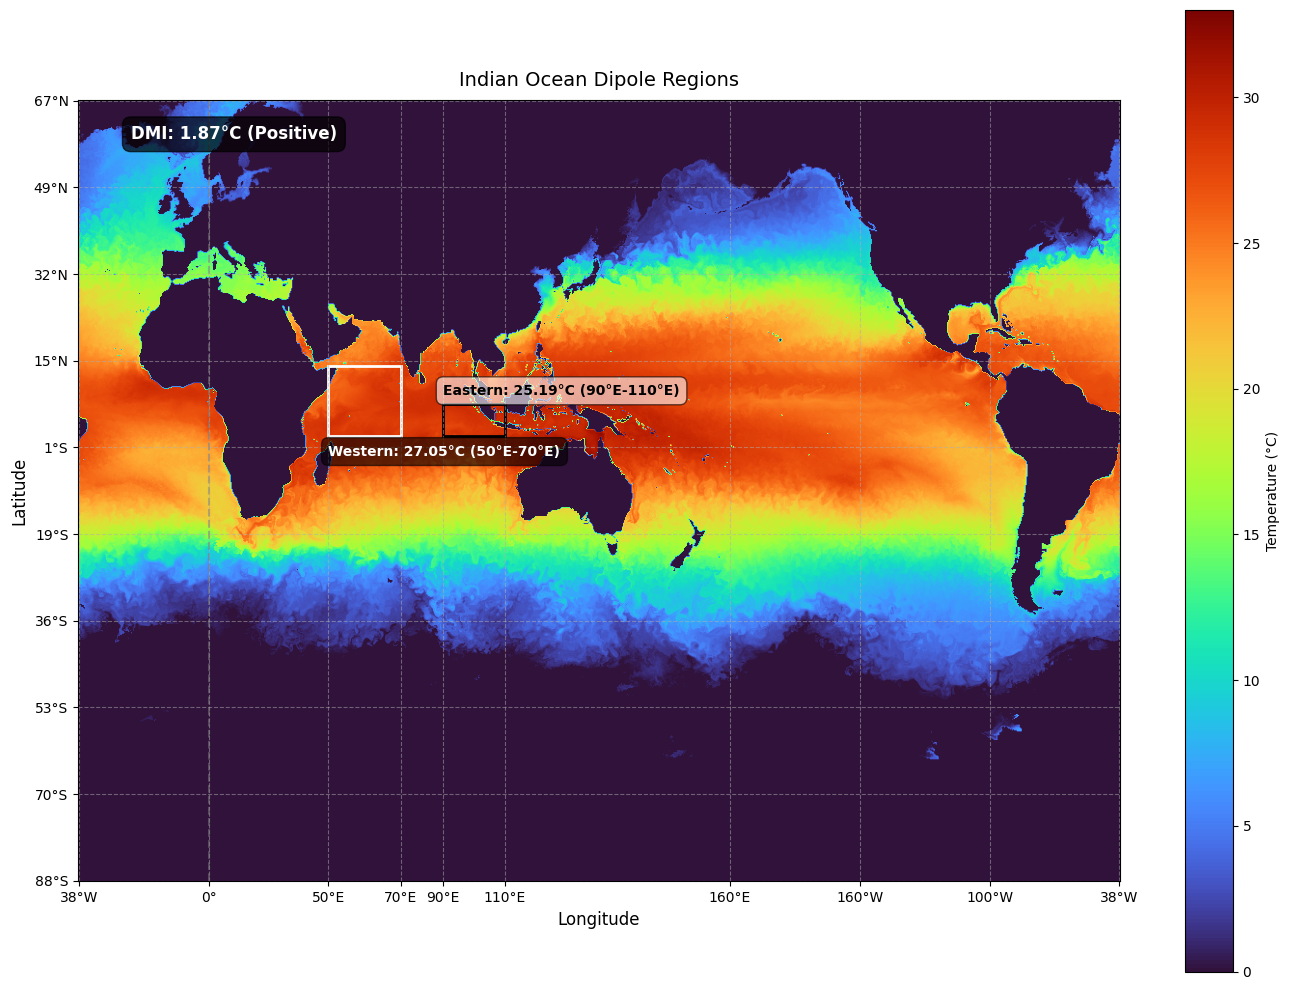

IOD visualization saved as 'iod_regions_exact.png'
Western region mean temperature: 27.05°C
Eastern region mean temperature: 25.19°C
Dipole Mode Index (DMI): 1.87°C
IOD Phase: Positive


Analyzing IOD time series:   0%|          | 0/432 [00:00<?, ?it/s]

Data shape: (6, 810, 1080)
Data min: -2.16780161857605, max: 32.9277229309082
Data shape: (6, 810, 1080)
Data min: -2.059051513671875, max: 32.641780853271484
Data shape: (6, 810, 1080)
Data min: -2.0582258701324463, max: 32.522125244140625
Data shape: (6, 810, 1080)
Data min: -2.0595431327819824, max: 32.457977294921875
Data shape: (6, 810, 1080)
Data min: -2.2151107788085938, max: 32.36143112182617
Data shape: (6, 810, 1080)
Data min: -2.0588302612304688, max: 32.58552551269531
Data shape: (6, 810, 1080)
Data min: -2.059222936630249, max: 32.83818435668945
Data shape: (6, 810, 1080)
Data min: -2.060000419616699, max: 32.989471435546875
Data shape: (6, 810, 1080)
Data min: -2.0591917037963867, max: 33.143638610839844
Data shape: (6, 810, 1080)
Data min: -2.097425699234009, max: 33.2730827331543
Data shape: (6, 810, 1080)
Data min: -2.059009552001953, max: 33.50639343261719
Data shape: (6, 810, 1080)
Data min: -2.0591695308685303, max: 33.5913200378418
Data shape: (6, 810, 1080)
Data m

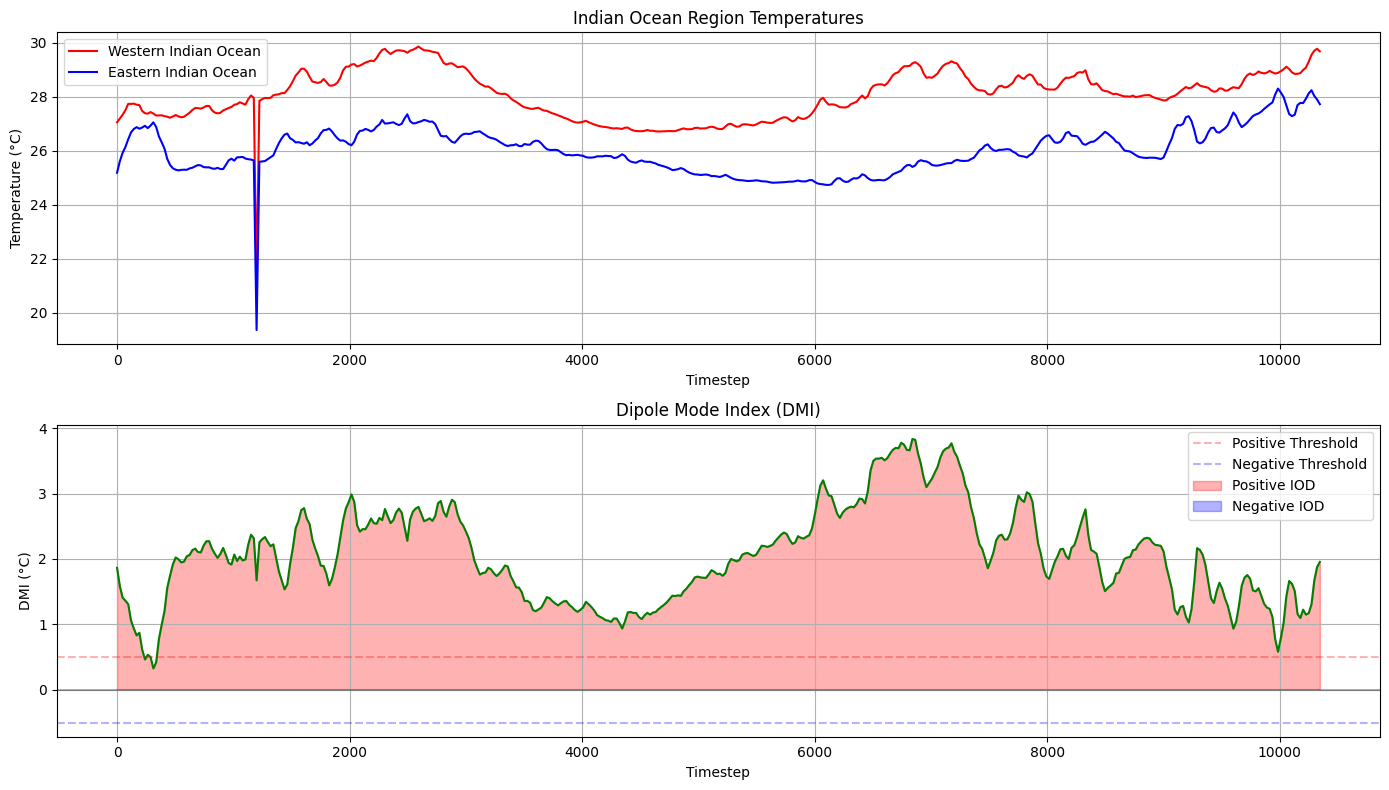

DMI time series analysis saved as 'dmi_timeseries.png'
Results saved to 'iod_analysis_results.csv'


In [31]:

# Load the dataset
db = load_temperature_dataset()

# Read temperature data for timestep 0
temp_data = read_temperature_data(db, timestep=0, resolution=-10)

# Visualize IOD regions and calculate DMI for a single timestep
# western_mean, eastern_mean, dmi = visualize_iod_regions(temp_data)
western_mean, eastern_mean, dmi = visualize_iod_regions_exact(temp_data)
print(f"Western region mean temperature: {western_mean:.2f}°C")
print(f"Eastern region mean temperature: {eastern_mean:.2f}°C")
print(f"Dipole Mode Index (DMI): {dmi:.2f}°C")
print(f"IOD Phase: {'Positive' if dmi > 0.5 else 'Negative' if dmi < -0.5 else 'Neutral'}")

# For time series analysis:
dmi_df = analyze_iod_timeseries(db, start_timestep=0, end_timestep=10366, step=24)  # daily analysis


In [43]:
def visualize_indian_ocean_region_enhanced(data, y_slice=(0.45, 0.71), x_slice=(0.2, 0.6), 
                                 western_region=(0.24, 0.31, 0.57, 0.66),
                                 eastern_region=(0.35, 0.41, 0.57, 0.61),
                                 timestep=0,
                                 vmin=0, vmax=33, cmap='turbo', 
                                 title='Indian Ocean Region Sea Surface Temperature',
                                 show_contours=True,
                                 contour_levels=np.arange(0, 35, 0.5),  # 0.5°C interval contours
                                 save_path='indian_ocean_temperature-2.png'):
    """
    Create and save an enhanced visualization of the Indian Ocean region with IOD analysis
    Includes options for contour lines and regional temperature gradient analysis
    
    Parameters:
    data (np.ndarray): Full temperature data array
    y_slice (tuple): Relative start and end points for y-axis (0-1)
    x_slice (tuple): Relative start and end points for x-axis (0-1)
    western_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) for Western IOD region
    eastern_region (tuple): (x_start_rel, x_end_rel, y_start_rel, y_end_rel) for Eastern IOD region
    timestep (int): Current timestep (for title labeling)
    vmin, vmax (float): Min and max values for colormap
    cmap (str): Matplotlib colormap name
    title (str): Plot title
    show_contours (bool): Whether to add contour lines to the visualization
    contour_levels (np.ndarray): Levels for contour lines
    save_path (str): Path to save the visualization
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # Set contour levels if not provided
    if contour_levels is None:
        contour_levels = np.arange(0, 35, 0.5)  # 0.5°C interval contours
    
    # Calculate region boundaries
    y_start = int(data.shape[0] * y_slice[0])
    y_end = int(data.shape[0] * y_slice[1])
    x_start = int(data.shape[1] * x_slice[0])
    x_end = int(data.shape[1] * x_slice[1])
    
    # Extract the region of interest
    region_data = data[y_start:y_end, x_start:x_end]
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(14, 10))

    ax.set_aspect('auto')
    
    # Define coordinate ranges
    lon_range = (37, 175)  # 37°E to 175°E
    lat_range = (-37, 37)  # 37°S to 37°N
    
    # Create the plot with temperature colormap
    im = ax.imshow(region_data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, 
                   extent=[lon_range[0], lon_range[1], lat_range[0], lat_range[1]])
    
    # Function to convert relative coordinates to lon/lat values
    def rel_to_lon(x_rel):
        # Map from relative position to longitude
        # Account for the fact that we're looking at a slice of the full data
        rel_within_slice = (x_rel - x_slice[0]) / (x_slice[1] - x_slice[0])
        # Map to the longitude range
        lon = lon_range[0] + rel_within_slice * (lon_range[1] - lon_range[0])
        return lon
    
    def rel_to_lat(y_rel):
        # Map from relative position to latitude
        # Account for the fact that we're looking at a slice of the full data
        rel_within_slice = (y_rel - y_slice[0]) / (y_slice[1] - y_slice[0])
        # Map to the latitude range
        lat = lat_range[0] + rel_within_slice * (lat_range[1] - lat_range[0])
        return lat
    
    # Calculate IOD region coordinates in longitude/latitude
    west_lon_start = rel_to_lon(western_region[0])
    west_lon_end = rel_to_lon(western_region[1])
    west_lat_start = rel_to_lat(western_region[2])
    west_lat_end = rel_to_lat(western_region[3])
    
    east_lon_start = rel_to_lon(eastern_region[0])
    east_lon_end = rel_to_lon(eastern_region[1])
    east_lat_start = rel_to_lat(eastern_region[2])
    east_lat_end = rel_to_lat(eastern_region[3])
    
    # Create meshgrid for contour plotting
    y_size, x_size = region_data.shape
    lons = np.linspace(lon_range[0], lon_range[1], x_size)
    lats = np.linspace(lat_range[0], lat_range[1], y_size)
    X, Y = np.meshgrid(lons, lats)
    
    # Calculate regional averages
    # Find indices within IOD regions
    west_indices = np.where(
        (X >= west_lon_start) & (X <= west_lon_end) & 
        (Y >= west_lat_start) & (Y <= west_lat_end)
    )
    east_indices = np.where(
        (X >= east_lon_start) & (X <= east_lon_end) & 
        (Y >= east_lat_start) & (Y <= east_lat_end)
    )
    
    # Extract temperatures and calculate DMI
    west_temp = np.nanmean(region_data[west_indices])
    east_temp = np.nanmean(region_data[east_indices])
    dmi = west_temp - east_temp
    
    # Add contour lines if requested
    if show_contours:
        try:
            # Add subtle contour lines across the entire map
            contour_interval = 1.0  # 1°C interval for labeled contours
            labeled_levels = np.arange(0, 35, contour_interval)
            cs = ax.contour(X, Y, region_data, levels=labeled_levels, colors='black', alpha=0.5)
            
            # Add contour labels (less frequent for readability)
            sparse_levels = np.arange(0, 35, 5)  # Label every 5°C for clarity
            cs_sparse = ax.contour(X, Y, region_data, levels=sparse_levels, colors='black', linewidths=1.5)
            ax.clabel(cs_sparse, inline=True, fontsize=10, fmt='%d°C')
            
            # Highlight the 27°C isotherm (often significant for IOD)
            cs_highlight = ax.contour(X, Y, region_data, levels=[27], colors='red', linewidths=2)
            # Fixed: removed fontweight parameter
            ax.clabel(cs_highlight, inline=True, fontsize=10, fmt='%d°C')
        except Exception as e:
            print(f"Warning: Could not draw contours: {e}")
            
    # Create rectangles for the IOD regions
    west_rect = plt.Rectangle((west_lon_start, west_lat_start), 
                            west_lon_end - west_lon_start, 
                            west_lat_end - west_lat_start,
                            linewidth=2, edgecolor='white', facecolor='none')
    ax.add_patch(west_rect)
    
    east_rect = plt.Rectangle((east_lon_start, east_lat_start), 
                            east_lon_end - east_lon_start, 
                            east_lat_end - east_lat_start,
                            linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(east_rect)
    
    # Add labels for the regions (positioned below/above the rectangles)
    ax.text(west_lon_start, west_lat_start - 5, 
           f'Western IOD: {west_temp:.2f}°C (50°E-70°E)', 
           color='white', fontsize=10, weight='bold',
           bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3'))
    
    ax.text(east_lon_start, east_lat_end + 5, 
           f'Eastern IOD: {east_temp:.2f}°C (90°E-110°E)', 
           color='black', fontsize=10, weight='bold',
           bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.3'))
    
    # Add DMI text with phase
    iod_phase = "Positive" if dmi > 0.5 else "Negative" if dmi < -0.5 else "Neutral"
    ax.text(lon_range[0] + 10, lat_range[1] - 10, 
           f'DMI: {dmi:.2f}°C ({iod_phase})', 
           color='white', fontsize=12, weight='bold', 
           bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.5'))
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Set x ticks (longitude) - create evenly spaced ticks
    lon_ticks = np.linspace(lon_range[0], lon_range[1], 10)
    ax.set_xticks(lon_ticks)
    ax.set_xticklabels([f'{int(lon)}°E' for lon in lon_ticks])
    
    # Set y ticks (latitude) - create evenly spaced ticks
    lat_ticks = np.linspace(lat_range[0], lat_range[1], 10)
    ax.set_yticks(lat_ticks)
    ax.set_yticklabels([f'{int(lat)}°N' if lat >= 0 else f'{abs(int(lat))}°S' for lat in lat_ticks])
    
    # Set axis labels
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Temperature (°C)', shrink=0.6, aspect=20)
    
    # Add timestep to title if provided
    if timestep > 0:
        title = f"{title} - Timestep {timestep}"
    
    # Add title
    ax.set_title(title, fontsize=14, pad=10)
    
    # Print the actual coordinates
    print(f"Western IOD region: {west_lon_start:.1f}°E to {west_lon_end:.1f}°E, {west_lat_start:.1f}°S to {west_lat_end:.1f}°N")
    print(f"Eastern IOD region: {east_lon_start:.1f}°E to {east_lon_end:.1f}°E, {east_lat_start:.1f}°S to {east_lat_end:.1f}°N")
    print(f"Western mean temperature: {west_temp:.2f}°C")
    print(f"Eastern mean temperature: {east_temp:.2f}°C")
    print(f"DMI: {dmi:.2f}°C ({iod_phase})")
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(save_path, dpi=150)
    plt.show()  # Show in notebook
    print(f"Enhanced visualization saved as '{save_path}'")
    print(f"Coordinate ranges: longitude {lon_range[0]}°E to {lon_range[1]}°E, latitude {abs(lat_range[0])}°S to {lat_range[1]}°N")
    
    return west_temp, east_temp, dmi

In [46]:
def generate_iod_time_series_analysis(data_loader_func, timesteps, 
                                     western_region=(0.24, 0.31, 0.57, 0.66),
                                     eastern_region=(0.35, 0.41, 0.57, 0.61),
                                     save_dir='contour'):
    """
    Generate time series and contour analyses for IOD across multiple timesteps
    
    Parameters:
    data_loader_func (function): Function that loads data for a given timestep
    timesteps (list): List of timesteps to analyze
    western_region (tuple): Western IOD region coordinates
    eastern_region (tuple): Eastern IOD region coordinates
    save_dir (str): Directory to save results and visualizations
    
    Returns:
    pandas.DataFrame: DataFrame with IOD analysis results
    """
    import pandas as pd
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    from datetime import datetime, timedelta
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize results storage
    results = {
        'timestep': [],
        'western_temp': [],
        'eastern_temp': [],
        'dmi': [],
        'phase': []
    }
    
    # Sample timesteps if too many (for detailed contour analysis)
    # Create some evenly spaced samples plus add key timestamps
    if len(timesteps) > 10:
        # Choose some representative timesteps for detailed analysis
        sample_count = min(5, len(timesteps))
        sample_step = len(timesteps) // sample_count
        sample_timesteps = timesteps[::sample_step][:sample_count]
    else:
        sample_timesteps = timesteps
    
    # Process each timestep
    for i, ts in enumerate(timesteps):
        print(f"Processing timestep {ts} ({i+1}/{len(timesteps)})...")
        
        # Load data for this timestep
        data = data_loader_func(ts)
        
        # For sample timesteps, create enhanced visualization with contours
        if ts in sample_timesteps:
            save_path = os.path.join(save_dir, f'iod_analysis_ts_{ts}.png')
            west_temp, east_temp, dmi = visualize_indian_ocean_region_enhanced(
                data, 
                western_region=western_region, 
                eastern_region=eastern_region,
                timestep=ts,
                show_contours=True,
                save_path=save_path
            )
        else:
            # Calculate western region coordinates
            west_x_start = int(data.shape[1] * western_region[0])
            west_x_end = int(data.shape[1] * western_region[1])
            west_y_start = int(data.shape[0] * western_region[2])
            west_y_end = int(data.shape[0] * western_region[3])
            
            # Calculate eastern region coordinates
            east_x_start = int(data.shape[1] * eastern_region[0])
            east_x_end = int(data.shape[1] * eastern_region[1])
            east_y_start = int(data.shape[0] * eastern_region[2])
            east_y_end = int(data.shape[0] * eastern_region[3])
            
            # Extract regional means
            west_temp = np.nanmean(data[west_y_start:west_y_end, west_x_start:west_x_end])
            east_temp = np.nanmean(data[east_y_start:east_y_end, east_x_start:east_x_end])
            dmi = west_temp - east_temp
        
        # Determine IOD phase
        if dmi > 0.5:
            phase = "Positive"
        elif dmi < -0.5:
            phase = "Negative"
        else:
            phase = "Neutral"
        
        # Store results
        results['timestep'].append(ts)
        results['western_temp'].append(west_temp)
        results['eastern_temp'].append(east_temp)
        results['dmi'].append(dmi)
        results['phase'].append(phase)
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Save results to CSV
    csv_path = os.path.join(save_dir, 'iod_analysis_results.csv')
    df.to_csv(csv_path, index=False)
    print(f"IOD analysis results saved to {csv_path}")
    
    # Create time series visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    # Plot regional temperatures
    ax1.plot(df['timestep'], df['western_temp'], 'r-', label='Western Indian Ocean', linewidth=2)
    ax1.plot(df['timestep'], df['eastern_temp'], 'b-', label='Eastern Indian Ocean', linewidth=2)
    ax1.set_ylabel('Temperature (°C)', fontsize=12)
    ax1.set_title('Indian Ocean Region Temperatures', fontsize=14)
    ax1.grid(True)
    ax1.legend(loc='best')
    
    # Plot DMI
    ax2.plot(df['timestep'], df['dmi'], 'g-', linewidth=2)
    ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Positive Threshold')
    ax2.axhline(y=-0.5, color='b', linestyle='--', alpha=0.7, label='Negative Threshold')
    
    # Add fill between
    ax2.fill_between(df['timestep'], df['dmi'], 0.5, 
                    where=(df['dmi'] > 0.5), 
                    color='red', alpha=0.3, label='Positive IOD')
    ax2.fill_between(df['timestep'], df['dmi'], -0.5, 
                    where=(df['dmi'] < -0.5), 
                    color='blue', alpha=0.3, label='Negative IOD')
    
    # Set labels
    ax2.set_xlabel('Timestep', fontsize=12)
    ax2.set_ylabel('DMI (°C)', fontsize=12)
    ax2.set_title('Dipole Mode Index (DMI)', fontsize=14)
    ax2.grid(True)
    ax2.legend(loc='best')
    
    # Highlight sample timesteps
    for ts in sample_timesteps:
        idx = df.index[df['timestep'] == ts][0]
        dmi_value = df.iloc[idx]['dmi']
        ax2.plot(ts, dmi_value, 'ro', markersize=8)
        ax2.text(ts, dmi_value + 0.2, f"t={ts}", fontsize=8)
    
    # Add annotation for peak DMI
    peak_idx = df['dmi'].idxmax()
    peak_ts = df.iloc[peak_idx]['timestep']
    peak_dmi = df.iloc[peak_idx]['dmi']
    ax2.annotate(f'Peak DMI: {peak_dmi:.2f}°C at t={peak_ts}',
                xy=(peak_ts, peak_dmi),
                xytext=(peak_ts + len(timesteps)//20, peak_dmi + 0.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=12, fontweight='bold')
    
    # Calculate phase statistics
    positive_pct = (df['phase'] == 'Positive').mean() * 100
    neutral_pct = (df['phase'] == 'Neutral').mean() * 100
    negative_pct = (df['phase'] == 'Negative').mean() * 100
    
    # Add text box with IOD phase statistics
    stats_text = (f"IOD Phase Distribution:\n"
                f"Positive: {positive_pct:.1f}%\n"
                f"Neutral: {neutral_pct:.1f}%\n"
                f"Negative: {negative_pct:.1f}%")
    
    # Position text box in the upper right corner of the bottom plot
    ax2.text(0.95, 0.95, stats_text,
            transform=ax2.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    time_series_path = os.path.join(save_dir, 'iod_time_series.png')
    plt.savefig(time_series_path, dpi=150)
    plt.show()
    print(f"Time series visualization saved as '{time_series_path}'")
    
    return df

Processing timestep 0 (1/432)...
Western IOD region: 50.8°E to 74.9°E, -2.8°S to 22.8°N
Eastern IOD region: 88.8°E to 109.4°E, -2.8°S to 8.5°N
Western mean temperature: 27.16°C
Eastern mean temperature: 25.16°C
DMI: 2.00°C (Positive)


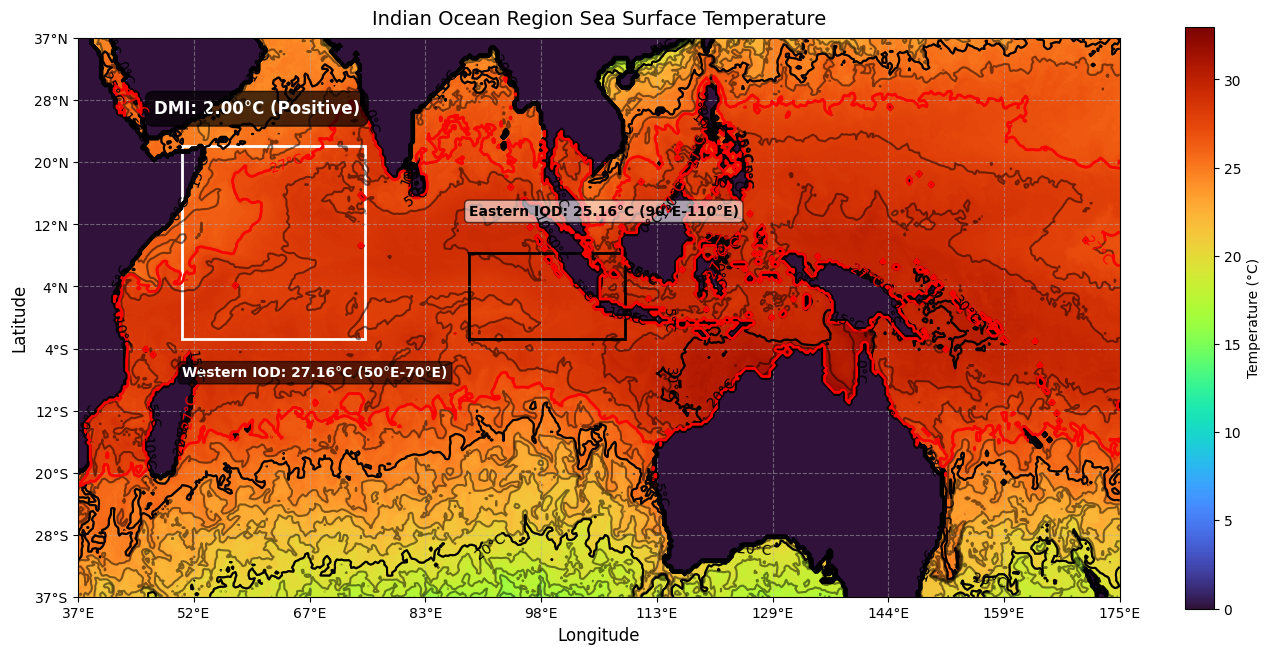

Enhanced visualization saved as 'iod_analysis_results-2/iod_analysis_ts_0.png'
Coordinate ranges: longitude 37°E to 175°E, latitude 37°S to 37°N
Processing timestep 24 (2/432)...
Processing timestep 48 (3/432)...
Processing timestep 72 (4/432)...
Processing timestep 96 (5/432)...
Processing timestep 120 (6/432)...
Processing timestep 144 (7/432)...
Processing timestep 168 (8/432)...
Processing timestep 192 (9/432)...
Processing timestep 216 (10/432)...
Processing timestep 240 (11/432)...
Processing timestep 264 (12/432)...
Processing timestep 288 (13/432)...
Processing timestep 312 (14/432)...
Processing timestep 336 (15/432)...
Processing timestep 360 (16/432)...
Processing timestep 384 (17/432)...
Processing timestep 408 (18/432)...
Processing timestep 432 (19/432)...
Processing timestep 456 (20/432)...
Processing timestep 480 (21/432)...
Processing timestep 504 (22/432)...
Processing timestep 528 (23/432)...
Processing timestep 552 (24/432)...
Processing timestep 576 (25/432)...
Pro

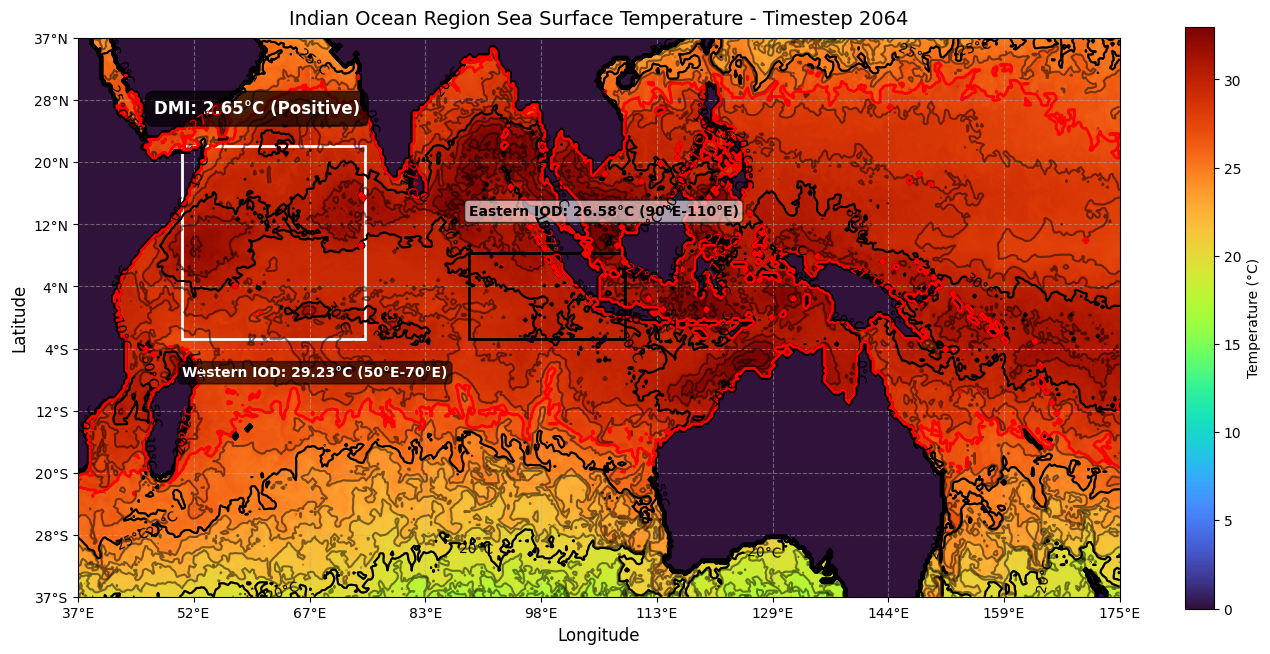

Enhanced visualization saved as 'iod_analysis_results-2/iod_analysis_ts_2064.png'
Coordinate ranges: longitude 37°E to 175°E, latitude 37°S to 37°N
Processing timestep 2088 (88/432)...
Processing timestep 2112 (89/432)...
Processing timestep 2136 (90/432)...
Processing timestep 2160 (91/432)...
Processing timestep 2184 (92/432)...
Processing timestep 2208 (93/432)...
Processing timestep 2232 (94/432)...
Processing timestep 2256 (95/432)...
Processing timestep 2280 (96/432)...
Processing timestep 2304 (97/432)...
Processing timestep 2328 (98/432)...
Processing timestep 2352 (99/432)...
Processing timestep 2376 (100/432)...
Processing timestep 2400 (101/432)...
Processing timestep 2424 (102/432)...
Processing timestep 2448 (103/432)...
Processing timestep 2472 (104/432)...
Processing timestep 2496 (105/432)...
Processing timestep 2520 (106/432)...
Processing timestep 2544 (107/432)...
Processing timestep 2568 (108/432)...
Processing timestep 2592 (109/432)...
Processing timestep 2616 (11

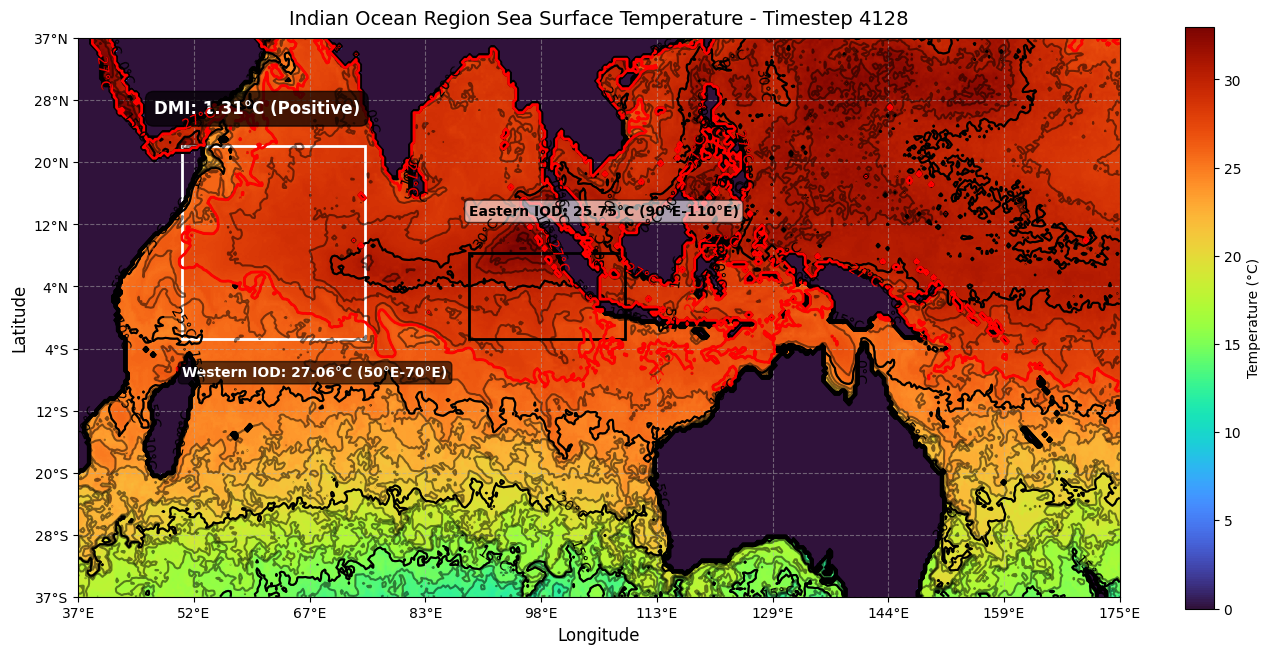

Enhanced visualization saved as 'iod_analysis_results-2/iod_analysis_ts_4128.png'
Coordinate ranges: longitude 37°E to 175°E, latitude 37°S to 37°N
Processing timestep 4152 (174/432)...
Processing timestep 4176 (175/432)...
Processing timestep 4200 (176/432)...
Processing timestep 4224 (177/432)...
Processing timestep 4248 (178/432)...
Processing timestep 4272 (179/432)...
Processing timestep 4296 (180/432)...
Processing timestep 4320 (181/432)...
Processing timestep 4344 (182/432)...
Processing timestep 4368 (183/432)...
Processing timestep 4392 (184/432)...
Processing timestep 4416 (185/432)...
Processing timestep 4440 (186/432)...
Processing timestep 4464 (187/432)...
Processing timestep 4488 (188/432)...
Processing timestep 4512 (189/432)...
Processing timestep 4536 (190/432)...
Processing timestep 4560 (191/432)...
Processing timestep 4584 (192/432)...
Processing timestep 4608 (193/432)...
Processing timestep 4632 (194/432)...
Processing timestep 4656 (195/432)...
Processing times

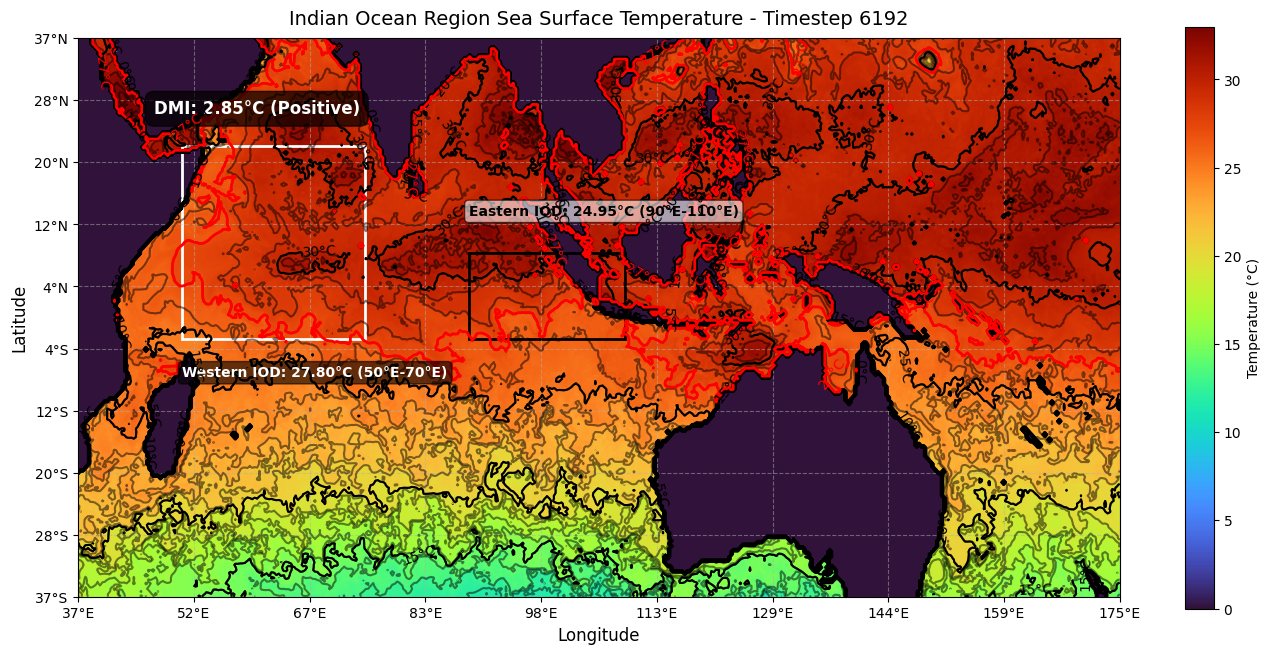

Enhanced visualization saved as 'iod_analysis_results-2/iod_analysis_ts_6192.png'
Coordinate ranges: longitude 37°E to 175°E, latitude 37°S to 37°N
Processing timestep 6216 (260/432)...
Processing timestep 6240 (261/432)...
Processing timestep 6264 (262/432)...
Processing timestep 6288 (263/432)...
Processing timestep 6312 (264/432)...
Processing timestep 6336 (265/432)...
Processing timestep 6360 (266/432)...
Processing timestep 6384 (267/432)...
Processing timestep 6408 (268/432)...
Processing timestep 6432 (269/432)...
Processing timestep 6456 (270/432)...
Processing timestep 6480 (271/432)...
Processing timestep 6504 (272/432)...
Processing timestep 6528 (273/432)...
Processing timestep 6552 (274/432)...
Processing timestep 6576 (275/432)...
Processing timestep 6600 (276/432)...
Processing timestep 6624 (277/432)...
Processing timestep 6648 (278/432)...
Processing timestep 6672 (279/432)...
Processing timestep 6696 (280/432)...
Processing timestep 6720 (281/432)...
Processing times

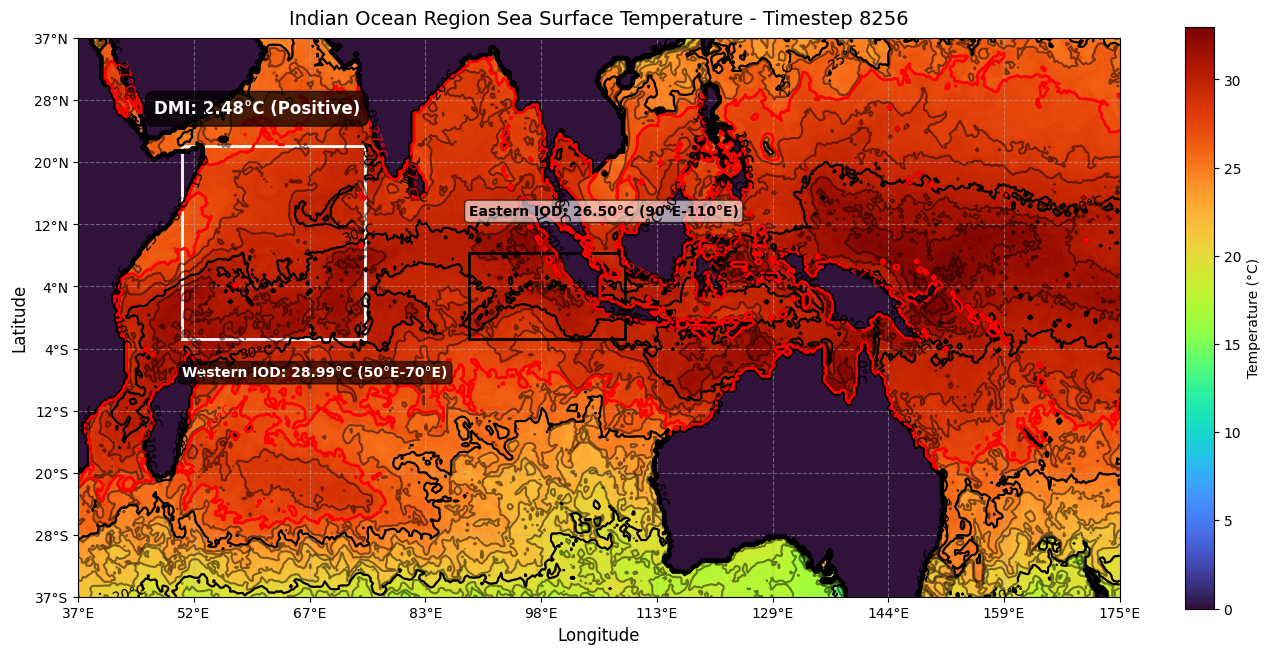

Enhanced visualization saved as 'iod_analysis_results-2/iod_analysis_ts_8256.png'
Coordinate ranges: longitude 37°E to 175°E, latitude 37°S to 37°N
Processing timestep 8280 (346/432)...
Processing timestep 8304 (347/432)...
Processing timestep 8328 (348/432)...
Processing timestep 8352 (349/432)...
Processing timestep 8376 (350/432)...
Processing timestep 8400 (351/432)...
Processing timestep 8424 (352/432)...
Processing timestep 8448 (353/432)...
Processing timestep 8472 (354/432)...
Processing timestep 8496 (355/432)...
Processing timestep 8520 (356/432)...
Processing timestep 8544 (357/432)...
Processing timestep 8568 (358/432)...
Processing timestep 8592 (359/432)...
Processing timestep 8616 (360/432)...
Processing timestep 8640 (361/432)...
Processing timestep 8664 (362/432)...
Processing timestep 8688 (363/432)...
Processing timestep 8712 (364/432)...
Processing timestep 8736 (365/432)...
Processing timestep 8760 (366/432)...
Processing timestep 8784 (367/432)...
Processing times

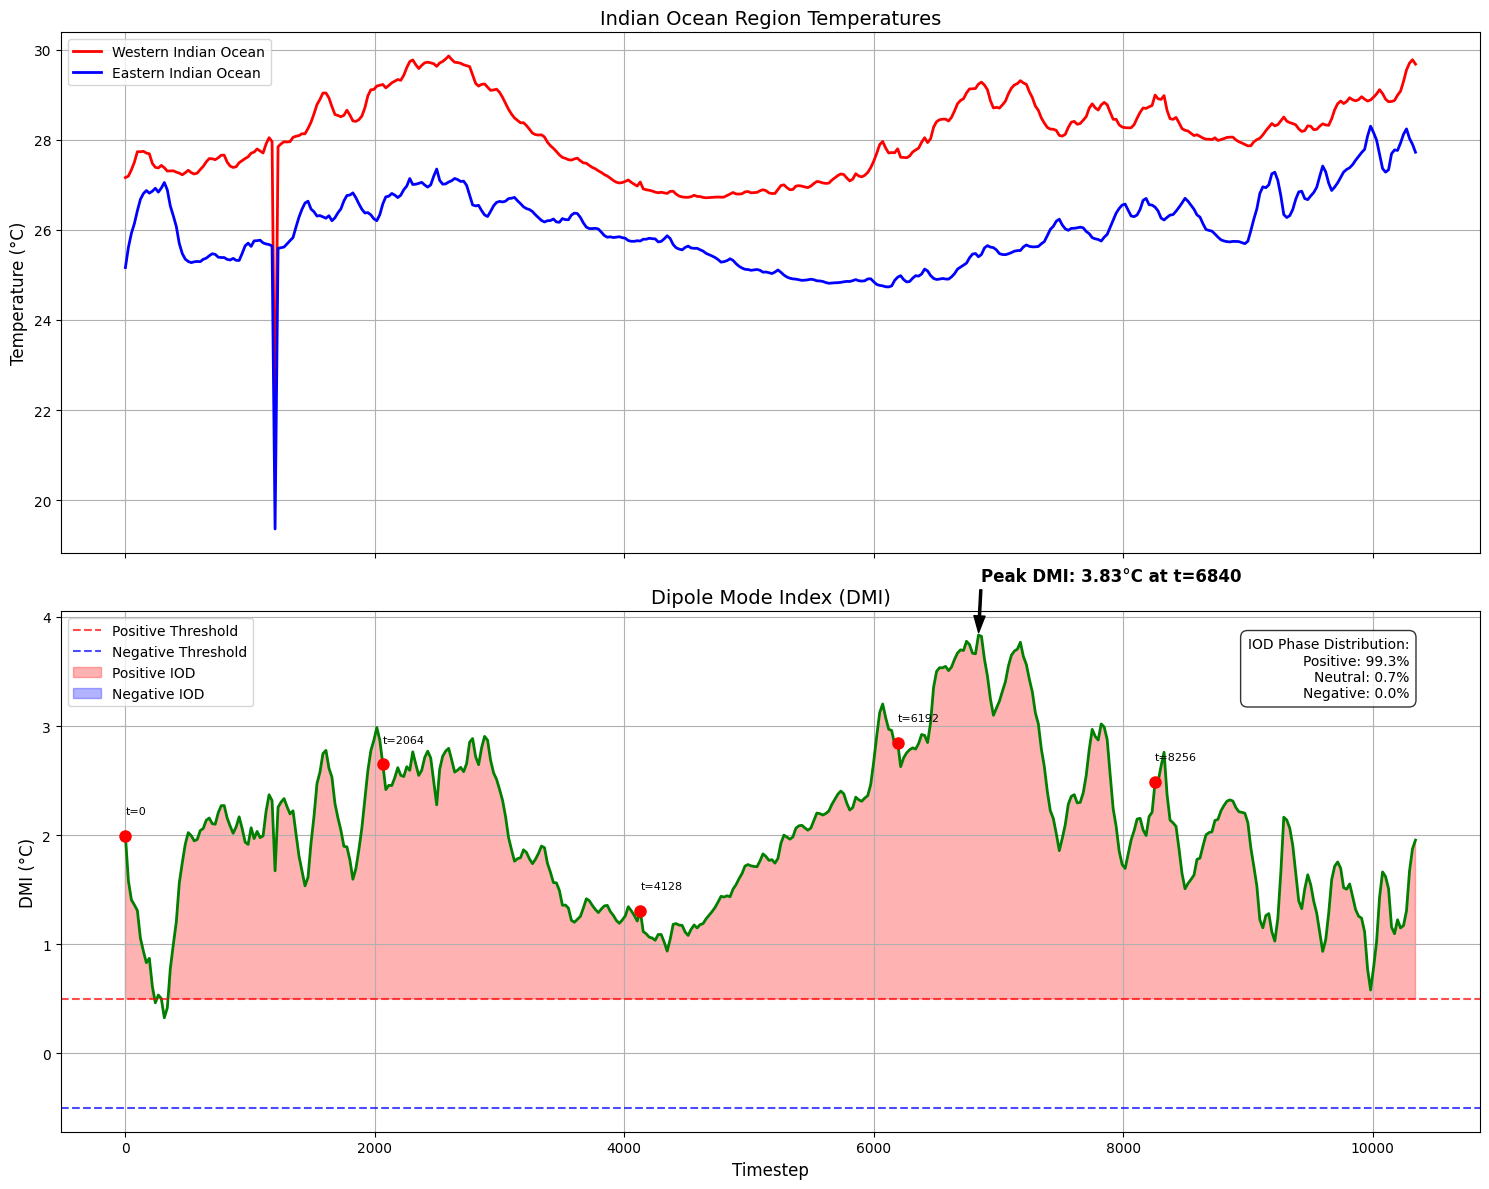

Time series visualization saved as 'iod_analysis_results-2/iod_time_series.png'


In [47]:
# Define data loader function
def load_temperature_data(timestep, resolution=-10):
    variable = 'theta'
    field = f"https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_{variable}/llc2160_{variable}.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
    
    db = ov.LoadDataset(field)
    data = db.read(time=timestep, quality=resolution)
    if len(data.shape) == 3:
        return data[0]  # Return surface layer if 3D
    return data

# Define timesteps to analyze
timesteps = range(0, 10366, 24)  # Daily samples

# Run the IOD time series analysis
iod_df = generate_iod_time_series_analysis(
    lambda ts: load_temperature_data(ts, -10),
    timesteps,
    save_dir='iod_analysis_results-2'
)

Western IOD region: 50.8°E to 74.9°E, -2.8°S to 22.8°N
Eastern IOD region: 88.8°E to 109.4°E, -2.8°S to 8.5°N
Western mean temperature: 28.71°C
Eastern mean temperature: 24.91°C
DMI: 3.80°C (Positive)


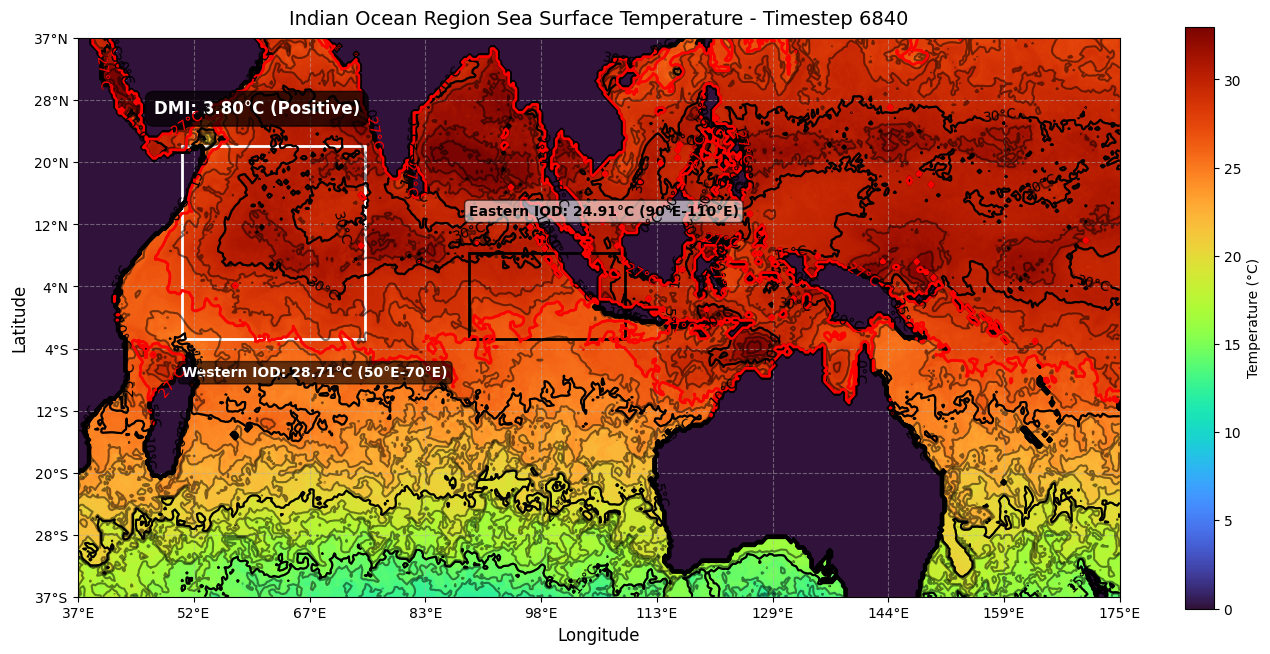

Enhanced visualization saved as 'peak_dmi_contours.png'
Coordinate ranges: longitude 37°E to 175°E, latitude 37°S to 37°N


(28.705372, 24.907084, 3.7982883)

In [45]:
temp_data = load_temperature_data(6500, -10)
visualize_indian_ocean_region_enhanced(
    temp_data, 
    timestep=6840, 
    show_contours=True,
    save_path='peak_dmi_contours.png'
)

climate anomaly ------ 

In [ ]:
def visualize_indian_ocean_region_anomaly(data, y_slice=(0.45, 0.71), x_slice=(0.2, 0.6), 
                                 western_region=(0.24, 0.31, 0.57, 0.66),
                                 eastern_region=(0.35, 0.41, 0.57, 0.61),
                                 timestep=0,
                                 vmin=0, vmax=33, cmap='turbo', 
                                 title='Indian Ocean Region Sea Surface Temperature',
                                 show_contours=True,
                                 contour_levels=np.arange(0, 35, 0.5),  # 0.5°C interval contours
                                 save_path='indian_ocean_temperature-2.png',
                                 clim_data=None,  # Added parameter
                                 anomaly_mode=False):  # Added parameter
    """
    Create and save an enhanced visualization of the Indian Ocean region with IOD analysis
    Includes options for contour lines and regional temperature gradient analysis
    
    Parameters:
    data (np.ndarray): Full temperature data array
    clim_data (np.ndarray): Climatology data for anomaly calculation
    anomaly_mode (bool): Whether to plot anomalies instead of absolute temps
    ... [rest of original parameters]
    """
    
    # --- Existing code ---
    # [Keep all previous imports and coordinate calculations]
    
    # Calculate region boundaries
    y_start = int(data.shape[0] * y_slice[0])
    y_end = int(data.shape[0] * y_slice[1])
    x_start = int(data.shape[1] * x_slice[0])
    x_end = int(data.shape[1] * x_slice[1])
    
    # Extract the region of interest
    region_data = data[y_start:y_end, x_start:x_end]
    
    # --- New Anomaly Calculation ---
    if anomaly_mode and clim_data is not None:
        # Get climatology for this region
        region_clim = clim_data[y_start:y_end, x_start:x_end]
        plot_data = region_data - region_clim
        # Override color settings for anomalies
        cmap = 'coolwarm'
        vmin, vmax = -3, 3  # Custom anomaly range
    else:
        plot_data = region_data
    
    # --- Modified Plotting Call ---
    im = ax.imshow(plot_data, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, 
                   extent=[lon_range[0], lon_range[1], lat_range[0], lat_range[1]])
    
    # --- Existing Contour Code ---
    if show_contours:
        try:
            # [Keep original contour code]
            
        except Exception as e:
            print(f"Warning: Could not draw contours: {e}")
            
    # --- New Gradient Vectors ---
    if show_contours:
        # Calculate temperature gradients
        dy, dx = np.gradient(plot_data)
        
        # Subsample vectors for clarity
        subsample = 10
        ax.quiver(X[::subsample,::subsample], Y[::subsample,::subsample],
                 dx[::subsample,::subsample], dy[::subsample,::subsample],
                 scale=25, color='black', width=0.002)
    
    # --- Rest of Existing Code ---
    # [Keep all remaining original code for regions, labels, etc.]
    
    return west_temp, east_temp, dmi

In [ ]:
visualize_indian_ocean_region_anomaly(
    current_data,
    clim_data=climatology,
    anomaly_mode=True,
    title='Indian Ocean SST Anomalies'
)